In [8]:
#Libraries
push!(LOAD_PATH, "/home/jberez/Projects/BostonHousing/docker")
using Gen
using PyPlot
using Distributions
using LinearAlgebra
using Flux
using Random
using Distances
using JLD
using Serialization
using StatsBase
using BNN

include("utils.jl");
include("LoadData.jl");

In [9]:
#Load Boston Housing Data

dx, dy, x_train, x_test, y_train, y_test = load_data(3);

In [13]:
#Network hyperparameters
k_real = 4 #Number of hidden nodes per layer
k_vector = [0.0 for i=1:k_real]
k_vector[k_real] = 1.0

#Layer hyperparameters
l_range = 8 #Maximum number of layers in the network
l_list = [Int(i) for i in 1:l_range]
l_real = 1;

#Hyperprior Hyperparameters
αᵧ = 1 #Regression Noise Shape
βᵧ = 1 #Regression Noise Scale/Rate
α₁ = 1 #Input Weights, Biases Shape
β₁ = 1 #Input Weights, Biases Scale/Rate
α₂ = 1 #Hidden & Output Weights Shape
β₂ = k_real; #Hidden & Output Weights Scale

#Bayesian Neural Network 

function G(x, trace)
    activation = relu
    l = trace[:l]
    ks = [trace[(:k,i)] for i=1:l]
    
    for i=1:l
        in_dim, out_dim = layer_unpacker(i, l, ks)
        W = reshape(trace[(:W,i)], out_dim, in_dim)
        b = reshape(trace[(:b,i)], trace[(:k,i)])
        nn = Dense(W, b, activation)
        x = nn(x)
    end
    
    Wₒ = reshape(trace[(:W,l+1)], 1, ks[l])
    bₒ = reshape(trace[(:b,l+1)], 1)
    
    nn_out = Dense(Wₒ, bₒ)
    return nn_out(x)
    
end;

#Probabilistic Model

@gen function interpolator(x)
    
    d = length(x[:,1])
    
    #Create a blank choicemap
    obs = choicemap()::ChoiceMap
    
    #Draw number of layers
    l ~ categorical([1/length(l_list) for i=1:length(l_list)])
    l_real = l
    obs[:l] = l
    
    #Create individual weight and bias vectors
    #Loop through hidden layers
    k = [Int(0) for i=1:l+1]
    for i=1:l
        k[i] = @trace(categorical(k_vector), (:k,i))
        obs[(:k,i)] = k[i]
    end
    k[l+1] = @trace(categorical([1.0]), (:k,l+1))
    obs[(:k,l+1)] = k[l+1]
    
    #####################################
    #New hyperparameter schedule - Mar 8#
    #####################################
    
    τ = [0.0 for i=1:l+1]
    τᵦ = [0.0 for i=1:l+1]
    σ = [0.0 for i=1:l+1]
    σᵦ = [0.0 for i=1:l+1]
    
    for i=1:l+1
        if i==1
            τ[i] = @trace(gamma(α₁,β₁), (:τ,i))
            τᵦ[i] = @trace(gamma(α₁,β₁), (:τᵦ,i))
        else
            τ[i] = @trace(gamma(α₂,β₂), (:τ,i))
            τᵦ[i] = @trace(gamma(α₁,β₁), (:τᵦ,i))
        end
        σ[i] = 1/τ[i]
        σᵦ[i] = 1/τᵦ[i]
    end
    
    #Noise Variance
    τᵧ ~ gamma(αᵧ,βᵧ)
    σᵧ = 1/τᵧ
    
    #Sample weight and bias vectors
    W = [zeros(k[i]) for i=1:l+1]
    b = [zeros(k[i]) for i=1:l+1]

    for i=1:l+1
        if i == 1
            h = Int(d * k[i])
        else
            h = Int(k[i-1] * k[i])
        end

        if i<=l
            #Hidden Weights
            u = zeros(h)
            S = Diagonal([σ[i] for j=1:length(u)])::Diagonal{<:Real}
            W[i] = @trace(mvnormal(u,S), (:W,i))
            obs[(:W,i)] = W[i]
            
            #Hidden Biases
            ub = zeros(k[i])
            Sb = Diagonal([σᵦ[i] for j=1:length(ub)])::Diagonal{<:Real}    
            b[i] = @trace(mvnormal(ub,Sb), (:b,i))
            obs[(:b,i)] = b[i]
        else
            #Output Weights
            u = zeros(k[l])
            S = Diagonal([σ[i] for j=1:length(u)])::Diagonal{<:Real}
            W[i] = @trace(mvnormal(u,S), (:W,i))
            obs[(:W,i)] = W[i]

            #Output Bias
            ub = zeros(1)
            Sb = Diagonal([σᵦ[i] for j=1:length(ub)])::Diagonal{<:Real}  
            b[i] = @trace(mvnormal(ub,Sb), (:b,i))
            obs[(:b,i)] = b[i]
        end
    end
    
    #Return Network Scores for X
    scores = transpose(G(x,obs))[:,1]
    
    #Regression Likelihood
    Sy = Diagonal([σᵧ for i=1:length(x[1,:])])::Diagonal{<:Real}
    y = @trace(mvnormal(vec(scores), Sy), (:y))

    return scores
    
end

obs_master = choicemap()::ChoiceMap
obs_master[:y] = y_train
obs = obs_master;

In [4]:
traces = deserialize("docker/Run1.jld");

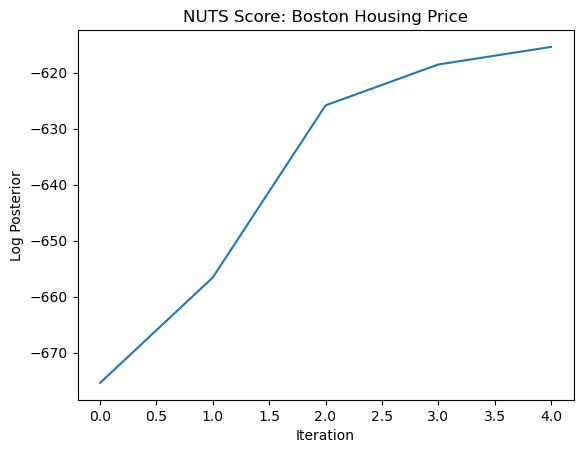

In [14]:
#-----------------------------------
#Plot Log Posterior Scores by Trace
#-----------------------------------

plot([get_score(trace) for trace in traces])
plt.title("NUTS Score: Boston Housing Price")
plt.xlabel("Iteration")
plt.ylabel("Log Posterior");

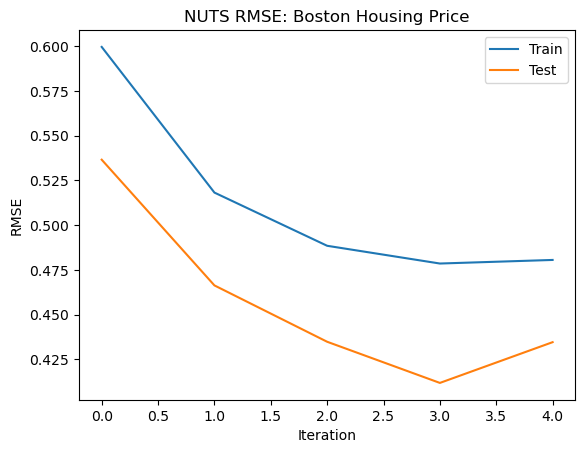

In [15]:
#-------------------------------
#Plot RMSE Train Scores by Trace
#-------------------------------

mses_train = []
for i=1:length(traces)
    trace = traces[i]
    pred_y = transpose(G(x_train,trace))[:,1]
    mse = mse_scaled(pred_y,y_train)

    push!(mses_train,mse)
end

mses_test = []
for i=1:length(traces)
    trace = traces[i]
    pred_y = transpose(G(x_test,trace))[:,1]
    mse = mse_scaled(pred_y,y_test)

    push!(mses_test,mse)
end

plot(mses_train,label="Train")
plot(mses_test, label="Test")
plt.title("NUTS RMSE: Boston Housing Price")
plt.xlabel("Iteration")
plt.ylabel("RMSE");
plt.legend()

best_trace = traces[1]
for i=1:length(traces)
    if get_score(traces[i]) > get_score(best_trace)
        best_trace = traces[i]
    end
end